In [1]:
#load the variables specific to this dataset 
#on brahma, SNPs have been split by DL CV split 
snp_prefix="/srv/scratch/annashch/gecco/manuscript_loci/splits"
model_prefix="/srv/scratch/annashch/deeplearning/gecco/crossvalid/v4/gecco.classification.SummitWithin200bpCenter"
test_set_prefix="/srv/scratch/annashch/deeplearning/gecco/crossvalid/v4/predictions"
n_folds=10 
num_tasks=5 
all_snps_basename="AnnotationList.labeled.collapsed.txt"
target_layer_idx=-2
tasks=['DNASEC','DNASEV','SW480','HCT116','COLO205']
outf_name="SNP_effect_predictions.txt"
interpretation_prefix="/srv/scratch/annashch/gecco/manuscript_loci/interpretation"
ref_fasta="/mnt/data/annotations/by_release/hg19.GRCh37/hg19.genome.fa"

In [2]:
#load the dependencies
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
import pickle 
from abstention.calibration import PlattScaling, IsotonicRegression
from keras.models import load_model, Model 

from kerasAC.metrics import recall, specificity, fpr, fnr, precision, f1
from kerasAC.custom_losses import get_ambig_binary_crossentropy
from kerasAC.generators import * 
from kerasAC.predict import get_model_layer_functor, get_layer_outputs


Using TensorFlow backend.


In [43]:
#dragonn imports
from dragonn.interpret import *
from dragonn.vis import * 

In [23]:
def load_keras_model(fold,model_prefix,target_layer_idx):    
    #load the model
    custom_objects={"recall":recall,
                    "sensitivity":recall,
                    "specificity":specificity,
                    "fpr":fpr,
                    "fnr":fnr,
                    "precision":precision,
                    "f1":f1,
                    "ambig_binary_crossentropy":get_ambig_binary_crossentropy()}
    model=load_model(".".join([model_prefix,str(fold)]),custom_objects=custom_objects)
    print("loaded model")
    #load the model to predict preacts 
    preact_model=Model(inputs=model.input,
                       outputs=model.layers[target_layer_idx].output)
    print("loaded preact model")
    return model,preact_model

In [56]:
def get_snp_generators(fold,snp_prefix,all_snps_basename,ref_fasta):
    snp_file='/'.join([snp_prefix,all_snps_basename+"."+str(fold)])
    snps=pd.read_csv(snp_file,header=0,sep='\t')
    if snps.shape[0]==0: 
        return None,None
    snp_ref_generator=SNPGenerator(snp_file,
                                   batch_size=1,
                                   ref_fasta=ref_fasta,
                                   allele_col="Ref")
    snp_alt_generator=SNPGenerator(snp_file,
                                   batch_size=1,
                                   ref_fasta=ref_fasta,
                                   allele_col="Alt")
    return snps, snp_ref_generator,snp_alt_generator

0
data_path:/srv/scratch/annashch/gecco/manuscript_loci/splits/AnnotationList.labeled.collapsed.txt.0
tasks:None
chroms_to_use:None
loaded labels
filtered on chroms_to_use
data.shape:(7, 8)
(7, 8)
data_path:/srv/scratch/annashch/gecco/manuscript_loci/splits/AnnotationList.labeled.collapsed.txt.0
tasks:None
chroms_to_use:None
loaded labels
filtered on chroms_to_use
data.shape:(7, 8)
(7, 8)
Got snp ref and alt generators
0
0
getting 'ism' value
ISM: task:0 sample:0
getting 'input_grad' value
getting 'deeplift' value
getting 'ism' value
ISM: task:0 sample:0
getting 'input_grad' value
getting 'deeplift' value
getting 'ism' value
ISM: task:1 sample:0


IndexError: index 1 is out of bounds for axis 0 with size 1

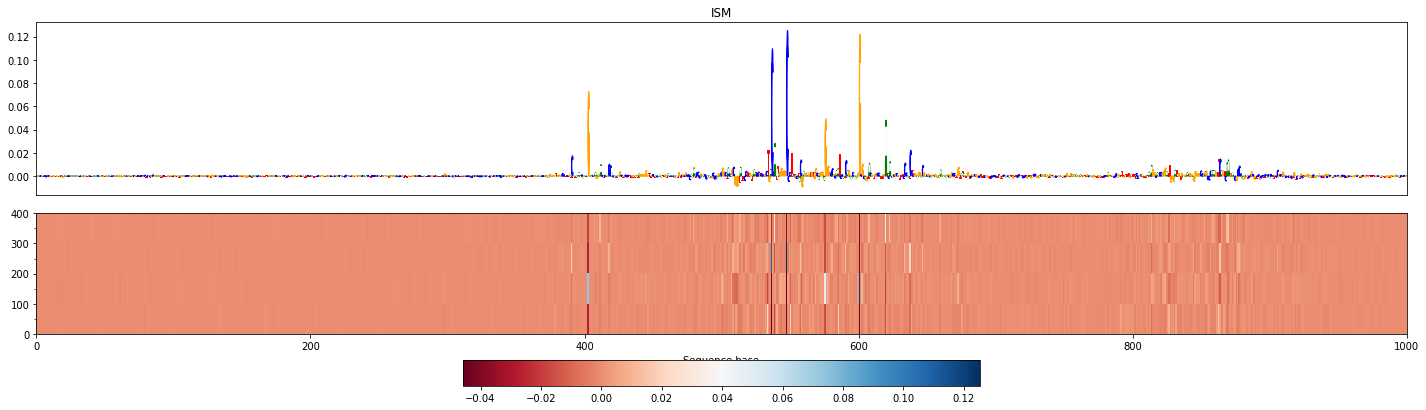

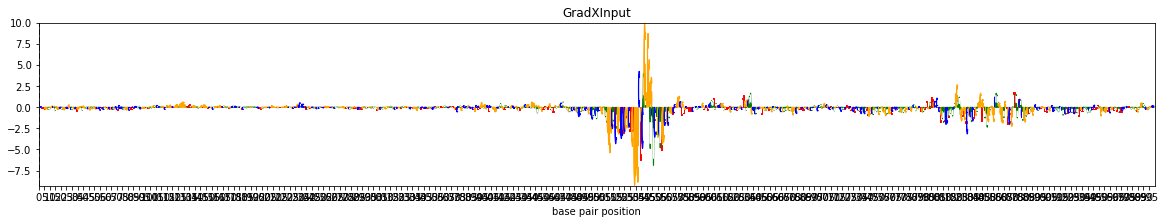

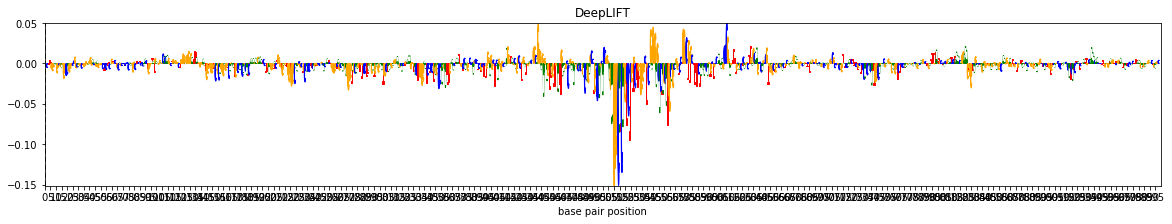

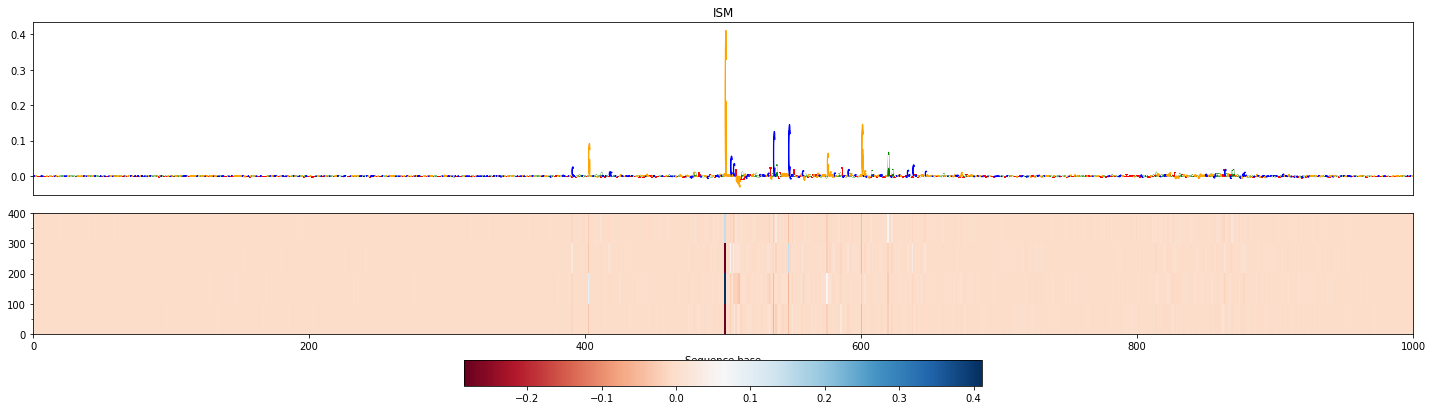

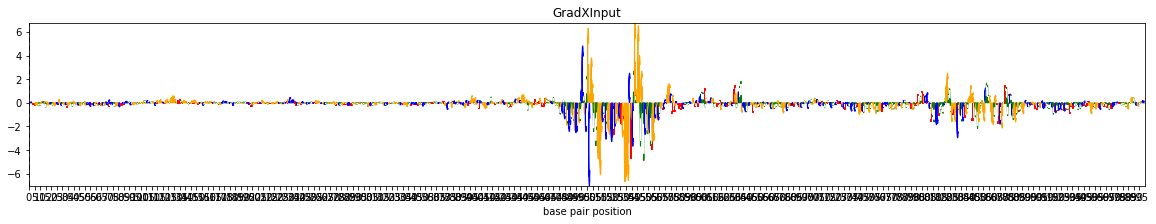

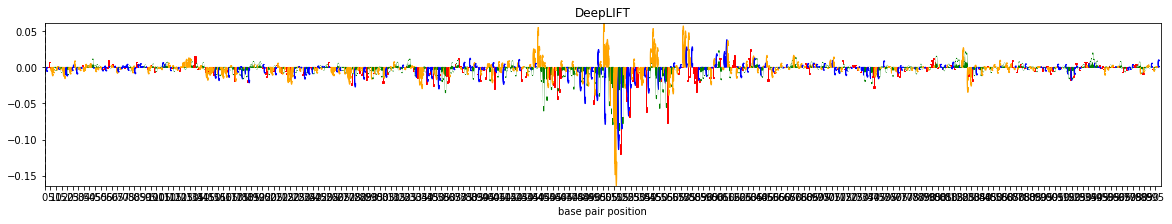

In [97]:
for fold in range(1): 
    try:
        snps, snp_ref_generator,snp_alt_generator=get_snp_generators(fold,
                                                                     snp_prefix,
                                                                     all_snps_basename,
                                                                     ref_fasta)
        print("Got snp ref and alt generators")
    except:
        print("fold:"+str(fold)+" appears to be empty, skipping")
        continue 
    model_string=".".join([model_prefix,str(fold)])
    #model,preact_model = load_keras_model(fold,model_prefix,target_layer_idx)

    num_snps=len(snp_ref_generator)
    for i in range(num_snps): 
        cur_ref_entry=snp_ref_generator[i]
        cur_alt_entry=snp_alt_generator[i]
        for task_idx in range(len(tasks)):
            ref_interpretations=multi_method_interpret(model_string,cur_ref_entry,task_idx,generate_plots=True)
            alt_interpretations=multi_method_interpret(model_string,cur_alt_entry,task_idx,generate_plots=True)



In [94]:
cur_ref_entry.shape

(1, 1, 1000, 4)

In [95]:
ref_interpretations=in_silico_mutagenesis(model,cur_ref_entry,0,target_layer_idx=-2)

(1, 1)
(1, 1, 1000, 4)
task:0 sample:0


In [96]:
ref_interpretations.shape

(1, 1, 1000, 4)

In [91]:
ig=input_grad(model,cur_ref_entry,5,0,target_layer_idx=-2)

(5, 1, 1, 1000, 4)


InvalidArgumentError: transpose expects a vector of size 5. But input(1) is a vector of size 4
	 [[{{node conv2d_1_8/convolution-0-TransposeNHWCToNCHW-LayoutOptimizer}} = Transpose[T=DT_FLOAT, Tperm=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_conv2d_1_input_8_0_0/_11169, PermConstNHWCToNCHW-LayoutOptimizer)]]
	 [[{{node gradients_12/conv2d_1_8/convolution_grad/Conv2DBackpropInput/_11201}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_841_gradients_12/conv2d_1_8/convolution_grad/Conv2DBackpropInput", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

In [78]:
ig.shape

(1, 1, 1000, 4)

In [70]:
dl=deeplift(model_string,cur_ref_entry,batch_size=1,target_layer_idx=-2,task_idx=0,num_refs_per_seq=10,reference="shuffled_ref",
            one_hot_func=None)

got score func!


In [92]:
model.layers[target_layer_idx].output.shape

TensorShape([Dimension(None), Dimension(5)])

In [82]:
model.input.shape

TensorShape([Dimension(None), Dimension(1), Dimension(1000), Dimension(4)])

In [86]:
from keras import backend as K
K.gradients(model.layers[target_layer_idx].output, [model.input])

[<tf.Tensor 'gradients_10/conv2d_1_8/convolution_grad/Conv2DBackpropInput:0' shape=(?, 1, 1000, 4) dtype=float32>]

In [87]:
K.gradients

<function keras.backend.tensorflow_backend.gradients(loss, variables)>

In [88]:
help(K.gradients)

Help on function gradients in module keras.backend.tensorflow_backend:

gradients(loss, variables)
    Returns the gradients of `loss` w.r.t. `variables`.
    
    # Arguments
        loss: Scalar tensor to minimize.
        variables: List of variables.
    
    # Returns
        A gradients tensor.



In [89]:
model.layers[target_layer_idx].output.shape

TensorShape([Dimension(None), Dimension(5)])